# Shallow Parsing or Text Chunking

Source: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

Based on the hierarchy we depicted earlier, groups of words make up phrases. There are five major categories of phrases:

- __Noun phrase (NP):__ These are phrases where a noun acts as the head word. Noun phrases act as a subject or object to a verb.
- __Verb phrase (VP):__ These phrases are lexical units that have a verb acting as the head word. Usually, there are two forms of verb phrases. One form has the verb components as well as other entities such as nouns, adjectives, or adverbs as parts of the object.
- __Adjective phrase (ADJP):__ These are phrases with an adjective as the head word. Their main role is to describe or qualify nouns and pronouns in a sentence, and they will be either placed before or after the noun or pronoun.
- __Adverb phrase (ADVP):__ These phrases act like adverbs since the adverb acts as the head word in the phrase. Adverb phrases are used as modifiers for nouns, verbs, or adverbs themselves by providing further details that describe or qualify them.
- __Prepositional phrase (PP):__ These phrases usually contain a preposition as the head word and other lexical components like nouns, pronouns, and so on. These act like an adjective or adverb describing other words or phrases.

Shallow parsing, also known as light parsing or chunking , is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. This includes POS tags as well as phrases from a sentence.

![](chunking_example.png)

# Project - Building your own Shallow Parser

The wonderful framework __`pattern`__ used to have an in-built shallow parser which worked really well! Sadly it has never been ported for Python 3.x meaning we can't use it.

But that gives us a fun project to implement this on our own!

We will leverage the __`conll2000`__ corpus for training our shallow parser model. This corpus is available in __`nltk`__ with chunk annotations and we will be using around 10K records for training our model. A sample annotated sentence is depicted as follows.

In [ ]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

From the preceding output, you can see that our data points are sentences that are already annotated with phrases and POS tags metadata that will be useful in training our shallow parser model.

In [ ]:
len(train_data), len(test_data)

We will leverage two chunking utility functions now.

- __`tree2conlltags`:__ to get triples of word, tag, and chunk tags for each token
- __`conlltags2tree`:__ to generate a parse tree from these token triples

We will be using these functions to train our parser. A sample is depicted below.

In [ ]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

The chunk tags use the IOB format. This notation represents Inside, Outside, and Beginning. 

- The __B- prefix__ before a tag indicates it is the beginning of a chunk
- The __I- prefix__ indicates that it is inside a chunk
- The __O tag__ indicates that the token does not belong to any chunk. 

The B- tag is always used when there are subsequent tags of the same type following it without the presence of O tags between them.

We will now define a function __`conll_tag_ chunks()`__ to extract POS and chunk tags from sentences with chunked annotations and a function called __`combined_taggers()`__ to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [ ]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

We will now define a class __`NGramTagChunker`__ that will take in tagged sentences as training input, get their (word, POS tag, Chunk tag) WTC triples, and train a __`BigramTagger`__ with a __`UnigramTagger`__ as the backoff tagger. 

We will also define a __`parse()`__ function to perform shallow parsing on new sentences

We will use this class to train on the `conll2000` chunked `train_data` and evaluate the model performance on the `test_data`

In [ ]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, 
                 tagger_classes=[UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tag_chunks(train_sentences)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

    def parse(self, tagged_sentence):
        if not tagged_sentence: 
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                         in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)

In [ ]:
# train chunker model  
ntc = NGramTagChunker(train_data)
ntc

In [ ]:
# evaluate chunker model performance
print(ntc.evaluate(test_data))

Our chunking model gets an accuracy of around 90% which is quite good! Let’s now leverage this model to shallow parse and chunk our sample news article headline which we used earlier

In [ ]:
sentence = 'This NLP Workshop is being organized by Analytics Vidhya as part of the DataHack Summit 2018'
sentence

In [ ]:
import nltk

nltk_pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

We can also visualize this in the form of a tree as follows. You might need to install ghostscript in case nltk throws an error.

Get it here: https://www.ghostscript.com/download/gsdnld.html

In [13]:
import os
os.environ['PATH'] = os.environ['PATH']+r';C:\Program Files\gs\gs9.25\bin'

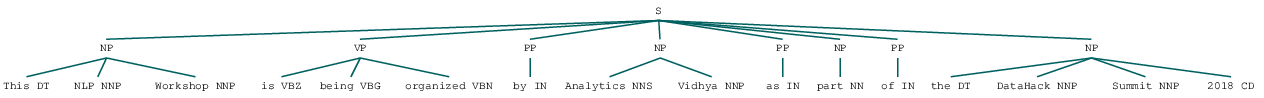

In [15]:
chunk_tree

The preceding output gives a good sense of sentence phrasal structure after shallow parsing the sentence